In [105]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [82]:
#get embryo IGS dataset
datapath = "/Users/paulreginato/Google Drive/genome seq in situ/Analysis/191202_embryo_analysis/embryo_seq_data_tables/Table_S2_embryo_data_table.csv"
source_data = pd.read_csv(datapath,index_col=False)

In [97]:
#function definitions

#Takes a dataframe 'data' and returns the xyz spatial positions as an array
def get_xyz(data):
    return np.column_stack((data.x_um_abs.to_numpy(),data.y_um_abs.to_numpy(),data.z_um_abs.to_numpy()))

#randomly assigns cluster label to data with cluster label -1 in the dataframe 'data'
def randomly_assign_unclustered(data):
    newdata=data.copy()
    unclustered=data.loc[data.cluster==-1]
    for index,row in unclustered.iterrows():
        newdata.at[index,'cluster']=np.random.choice([0,1])+1
    return newdata

#drops data from the dataframe 'data' that does not have 2 clusters numbered 1 and 2
def remove_triples_and_singles(data):
    data_c=data.copy()
    cell_indices=data.cell_index.unique()
    for cell_index in cell_indices:
        cell = data.loc[data.cell_index==cell_index]
        chr_nums=cell.chr.unique()
        for chr_num in chr_nums:
            chrom=cell.loc[cell.chr==chr_num]
            if (len(chrom.cluster.unique())!=2):
                data_c=data_c.drop(index=chrom.index)
    return data_c

#Gets pairs of cell indices for cells within and between embryos. 'data' is a dataframe.
#Returns a list of pairs of cell indices, where each pair is a list with two entries.
def get_within_between_pairs(data):
    data_copy = data.copy()
    
    #get all indices
    cell_indices = data_copy.cell_index.unique()
    
    #list of pairs of indices of cells within or between embryos
    within_index_pairs=[]
    between_index_pairs=[]
    
    #get index pairs between embryo
    for i in range(len(cell_indices)):
        cii=cell_indices[i]
        ei=data_copy.loc[data_copy.cell_index==cii].iloc[0].embryo_id
        
        for j in range(i+1,len(cell_indices)):
            cij=cell_indices[j]
            ej=data_copy.loc[data_copy.cell_index==cij].iloc[0].embryo_id
            
            if ei==ej:
                within_index_pairs.append([cii,cij])
            else:
                between_index_pairs.append([cii,cij])
        
    return within_index_pairs,between_index_pairs

#For each cell index in the dataframe 'data', produce a chromosome distance matrix, where the distance between chromosome 
#territories is calculated as the distance beteween their centers. Uses 'measure' to calculate the center of 
#a chromosome territory. 'hap' indicates whether to build a haplotype-resolved distance matrix.
#Returns a list of distance matrices and a list of cell indices corresponding to the distance matrices.
def get_distance_matrices(data,measure=np.mean,hap=0):
    
    m_list=[] #will contain the distance matrices for all cells
    
    cell_indices = data.cell_index.unique() 
    
    #get distance matrix for each cell
    for ci in cell_indices:
        cell=data.loc[data.cell_index==ci]
        
        if hap==0:
            c_m=get_clust_resolved_non_hap_chr_dist_mat(cell,np.arange(1,20),measure=measure)
        elif hap==1:
            c_m=get_diploid_distance_matrix(cell,np.arange(1,20))
            
        m_list.append(c_m)
        
    cell_index_list = list(cell_indices) #list of cell indices corresponding to the distance matrices
    
    return m_list,cell_index_list


#Generates a chromosome distance matrix. The distance between two chromosome territories is calculated as the
#distance between their centers, where the centers are calculated using 'measure'. For information on how this
#function distinguishes between chromosome territories while remaining agnostic to haplotype, see the section
#"Construction of single-cell autosome distance matrices" in the Materials and Methods section of the 
#Supplementary Text. 'cell' is a dataframe containing data for one cell, and
#'cnums' is a list of chromosome numbers to use in construction of the matrix.
#Returns the distance matrix as an array.
def get_clust_resolved_non_hap_chr_dist_mat(cell,cnums,measure=np.mean):
    
    #make array to hold the xyz positions of the centers of the bins
    centers = np.empty((len(cnums)*2,3))
    centers[:] = np.nan
    
    #get bin centers
    for cn in cnums:
        chrom = cell.loc[cell.chr==cn]
        cl_nums = chrom.cluster.unique()
        
        #if the chromosome is not present in the data, continue
        if len(cl_nums)==0:continue

        assert len(cl_nums)==2
        
        cl0i=(cn-1)*2 #index of the 0th cluster for the current chromosome in the centers array
        
        #iterate through both chromosome territories
        for i in [0,1]:
            cln=cl_nums[i]
            cl = chrom.loc[chrom.cluster==cln]
            centers[cl0i+i]=measure(get_xyz(cl),axis=0)
    
    #calculate matrix of pairwise distances beteween centers of chromosome territories
    m=sp.spatial.distance.cdist(centers,centers)
    
    #aggregate distances for both homologs to be haplotype-agnostic
    evens=np.arange(0,m.shape[0],2,dtype=int)
    odds=np.arange(1,m.shape[0],2,dtype=int)
    m=m[:,evens]+m[:,odds]
    m=m[evens,:]+m[odds,:]
    
    #double the diagonal, because off-diagonal entries have been created through the sum of four distances,
    #while the diagonals have been created through the sum of two distances and two zeros
    diag_i=np.diag_indices(m.shape[0])
    m[diag_i]=m[diag_i]*2
    
    #divide the matrix by 4, since 4 measurements have been added to produce each entry
    m=m/4
    
    return m

#Takes a list of pairs of cell indices as 'index_pair_list', a list of cell indices as 'cell_indices',a list of
#chromosome distance matrices corresponding to the list of cell indices, a list of distance matrices
#correspondinng to the list of indices, and a minimum required number of 
#chromosomes that must be non-nan in two matrices in order to compare them.
#Returns a list of correlations between the distance matrices for the pairs of cell indices.
def get_corrs_for_list_of_pairs(index_pair_list,cell_indices,m_list,min_chrs=6):
    
    #make array to store the correlation between each pair of matrices
    corrs=np.empty(len(index_pair_list))
    corrs[:]=np.nan
    cell_indices_array=np.array(cell_indices,dtype=int)
    
    #find correlation of distance matrices for each pair of cell indices
    for i in range(len(index_pair_list)):
        ip=index_pair_list[i]
        i0=ip[0]
        i1=ip[1]
        
        #find the index of i0 and i1 in the cell_indices array
        i0i=np.nonzero(cell_indices_array==i0)[0][0]
        i1i=np.nonzero(cell_indices_array==i1)[0][0]
        
        #get the distance matrices for cell indices i0 and i1
        m0=m_list[i0i]
        m1=m_list[i1i]
        
        #find if at least min_chrs chromosomes are shared between the two matrices
        #start by finding a row in each matrix that is not completely nan
        for j in range(m0.shape[0]):
            r0 = m0[j,:]
            if np.sum(~np.isnan(r0))!=0:
                break
                
        for j in range(m1.shape[0]):
            r1 = m1[j,:]
            if np.sum(~np.isnan(r1))!=0:
                break
    
        #find the indices where both matrices don't have nan
        filt = (np.isnan(r0)+np.isnan(r1))==0
    
        #reduce the rows to only indices that are not nan for both
        r0_filt =r0[filt]
        r1_filt = r1[filt]
        
        #if at least min_chrs are shared, find the correlation between the two matrices
        if sum(~np.isnan(r0_filt))>=min_chrs:
            assert (sum(~np.isnan(r0_filt))==sum(~np.isnan(r1_filt)))
            
            #get the correlation between the two matrices
            corrs[i]=get_matrix_corr(m0,m1)
        
    return corrs

#Takes two distance matrices as arrays and returns the correlation betweeen their entries
def get_matrix_corr(m0,m1):
    #unravel the upper triangular, including the diagonal, of the two matrices 
    ut_ind = np.triu_indices(m0.shape[0],k=0)
    m0_urav = m0[ut_ind]
    m1_urav = m1[ut_ind]
    
    #find indices where both unraveled matrices are not nan
    filt = (np.isnan(m0_urav)+np.isnan(m1_urav))==0
    
    #reduce the matrices to only indices that are not nan for both
    m0_filt = m0_urav[filt]
    m1_filt = m1_urav[filt]
    
    #if the two matrices share no indices that are not nan, return nan. Otherwise, findn the pearson correlation.
    if sum(~np.isnan(m0_filt))==0:
        r=np.nan
    else:
        #get pearson's r
        r = sp.stats.pearsonr(m0_filt,m1_filt)[0]
    
    return r



#Find the within-embryo pairs of cells pairs that correspond to putative sisters and cousins for 4-cell embryos.
#Takes a list of correlations, a list of index pairs corresponding to the correlations, and a datatable.
#Returns an array of putative sister correlations, an array of putative cousin correlations, and a list of the
#embryo_id for the embryos examined. It also returns a list of the embryo_id of embryos for which all 6 
#pairwise comparisons could be made, a list of ordered lists of the pairwise correlations of within embryos
#for which all 6 pairwise comparisons could be made, and the indices within the ordered lists that correspond
#to putative sisters.

#There will always be n=3 or n=6 pairs per 4-cell embryo, depending whether it contains 3 or 4 complete cells.
#Putatively designate pairs of cells as sisters and cousins by the followign rules, where
#n is the number of pairs and m is the number of correlations that could be calculated:
#1. If n==3:
#  a) If m==3, the most correlated pair is called as sisters, and the twoo least correlated pairs are called cousins
#  b) If m==2, the least correlated pair is called as cousin.
#  c) If m<=1, exclude.
#2. If n==6:
#  a) If m == 6, the most correlated pair is called as sister, other two cells in the embryo are also called sisters,
# and the remaining pairs of cells are called cousins 
#  b) If m==5, the most correlated pair is called as sisters, and the three least correlated pairs are called cousins
#  c) If m==3 or m==4, the least correlateed m-2 pairs are called as cousins
#  d) If m<=2, exclude
def putative_sis_cous(corrs,index_pairs,data):
    assert len(corrs)==len(index_pairs)
    
    complete_embryo_nums=[] #keeps track of the embryos that had all 6 pairs analyzed
    complete_embryo_corrs=[] #will contain ordered list of correlations for each embryo with all 6 pairs analyzed
    complete_embryo_sis=[] #will keep track of the indices of the putative sisters
    
    e_num=-1 #keeps track of the embryo number for the index pair
    n=0 #keeps track of the number of pairs in an embryo
    sis_corrs=[] #list of the putative sister correlations
    cous_corrs=[] #list of the putative cousin correlations
    e_corrs=np.empty((6))#keeps track of the correlations within an embryo
    e_corrs[:]=np.nan 
    e_pairs=[]#keeps track of the index pairs within an embryo
    e_list=[]#shows the ordering of the embryos
    
    #iterate through the pairs and the corresponding correlations
    for i in range(len(index_pairs)):
        #get the indices in the pair
        ip = index_pairs[i]
        i0=ip[0]
        i1=ip[1]
        
        #get the embryo number
        e0=data.loc[data.cell_index==i0].iloc[0].embryo_id
        e1=data.loc[data.cell_index==i1].iloc[0].embryo_id
        
        assert e0==e1
        
        #check if we've reached a new embryo
        if e0!=e_num:
            e_list.append(e0)
            assert ((n==0)|(n==3)|(n==6))
            
            #if we've reached a new embryo, apply the rules and add to sis_corrs and cous_corrs
            m=e_corrs[~np.isnan(e_corrs)] #get the non-nan correlations
            m=np.sort(m)[::-1] #sort correlations in descending order
            lenm=len(m) #find the number of correlations
            
            if n==3:
                #Rule 1a
                if lenm==3:
                    sis_corrs.append(m[0])
                    cous_corrs=cous_corrs+list(m[1:])
                #Rule 1b
                elif lenm==2:
                    cous_corrs.append(m[1])
            
            elif n==6:
                #Rule 2a
                if lenm==6:
                    #find max corr and the corresponding cell indices
                    max_corr = m[0]
                    sis0_ip_ind = np.nonzero(e_corrs==max_corr)[0][0] #the position in e_corrs where the
                                                                            #max showed up
                    sis0_ip = e_pairs[sis0_ip_ind] #the index pair whose cells are best correlated is the first
                                                        #putative pair of sisters

                    #find the position in e_pairs that contains the indices not included in sis1_ip
                    sis1_ip_ind=np.nan
                    for j in range(6):
                        ipj=e_pairs[j]
                        #if none of the indices in index pair j overlap with the sis0 index pairs, we've found
                        #the other pair of sisters
                        if ((ipj[0] not in sis0_ip)&(ipj[1] not in sis0_ip)):
                            sis1_ip_ind=j
                            sis1_corr=e_corrs[sis1_ip_ind]
                            break
                            
                    #record the sister correlations
                    sis_corrs=sis_corrs+[e_corrs[sis0_ip_ind],sis1_corr]
                    all_indices=np.arange(6)
                    
                    #record the cousin correlations, which are all the correlations in the embryo that are not
                    #sisters
                    cous_corrs=cous_corrs+list(e_corrs[(all_indices!=sis0_ip_ind)&(all_indices!=sis1_ip_ind)])
                    
                    #record the ranks of the putative sister pairs in the list of correlations within the embryo
                    sis_ranks=np.zeros(6)
                    sis_ranks[0]=1
                    sis_ranks=sis_ranks+(m==sis1_corr).astype(int)
                    
                    #record info about the embryo for which all 6 pairs of cells could be analyzed
                    complete_embryo_nums.append(e_num)
                    complete_embryo_corrs.append(m)
                    complete_embryo_sis.append(sis_ranks)

                #Rule 2b
                if lenm==5:
                    sis_corrs.append(m[0])
                    cous_corrs=cous_corrs+list(m[2:])
                #Rule 2c
                if ((lenm==4)|(lenm==3)):
                    cous_corrs=cous_corrs+list(m[2:])
                    
            #set the new e_num, reset n, reset e_corrs, reset e_pairs
            e_num=e0
            n=0
            e_corrs[:]=np.nan
            e_pairs=[]
        
        #regardless if we reached a new embryo, record the new correlation and increment n
        e_corrs[n]=corrs[i]
        e_pairs.append(ip)
        n+=1
    
    return np.array(sis_corrs), np.array(cous_corrs),e_list,complete_embryo_nums,complete_embryo_corrs,complete_embryo_sis

In [98]:
#get autosome data and remove outliers
autosomes = source_data.loc[(source_data.chr<20)&(source_data.inlier==1)]

"""
Randomly assign cluster labels for unclustered data points. These data were not separable into two clusters
due to spatially overlapping homologs, but can be treated as two overlapping clusters by randomly assigning.
"""
clustered=randomly_assign_unclustered(autosomes)

#remove chromosomes that are present in only one or three copies (aneuploid)
clustered = remove_triples_and_singles(clustered)

#get data for 2-cell and 4-cell embryos
twocell=clustered.loc[(clustered.stage=='2cell')]
fourcell=clustered.loc[(clustered.stage=='4cell')]

#get pairs of cells within and between embryos
twocell_wi_pairs,twocell_btw_pairs=get_within_between_pairs(twocell)
fourcell_wi_pairs,fourcell_btw_pairs=get_within_between_pairs(fourcell)

#get distance matrices for fourcell and twocell
twocell_m,twocell_indices=get_distance_matrices(twocell,measure=np.mean)
fourcell_m,fourcell_indices=get_distance_matrices(fourcell,measure=np.mean)


#get correlations of the distance matrices for each pair of cells within and between embryos
twocell_wi_corrs=get_corrs_for_list_of_pairs(twocell_wi_pairs,twocell_indices,twocell_m)
twocell_btw_corrs=get_corrs_for_list_of_pairs(twocell_btw_pairs,twocell_indices,twocell_m)
fourcell_wi_corrs=get_corrs_for_list_of_pairs(fourcell_wi_pairs,fourcell_indices,fourcell_m)
fourcell_btw_corrs=get_corrs_for_list_of_pairs(fourcell_btw_pairs,fourcell_indices,fourcell_m)

#remove nans from the correlation arrays
corr_arrays = [twocell_wi_corrs,twocell_btw_corrs,fourcell_wi_corrs,fourcell_btw_corrs]
for i in range(len(corr_arrays)):
    corr_arrays[i]=corr_arrays[i][~np.isnan(corr_arrays[i])]
    
#get putative sisters and cousins
putative_sis_corrs,putative_cous_corrs,embryo_list,complete_e_nums,complete_e_corrs,complete_e_sis=putative_sis_cous(fourcell_wi_corrs,
                                                                                                                         fourcell_wi_pairs,
                                                                                                                         fourcell)

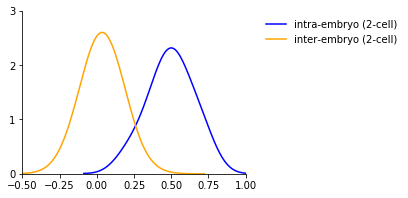

In [106]:
#plot the pairwise correlations of chromosome positioning for pairs within and between 2-cell embryos 

bw=0.1
fig1,ax1=plt.subplots(figsize=(4,3))
sns.distplot(corr_arrays[0], hist = False, kde = True,ax=ax1,color='blue',label='intra-embryo (2-cell)',
             kde_kws={'bw': bw})
sns.distplot(corr_arrays[1], hist = False, kde = True,ax=ax1,color='orange',label='inter-embryo (2-cell)',
             kde_kws={'bw': bw})


ax1.set_xlim(-0.5,1)
ax1.legend(bbox_to_anchor=(1.05, 1),frameon=False)

# Hide the right and top bounding areas
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax1.set_yticks([0,1,2,3])

#plt.savefig('2cell_sisters_vs_null.svg')

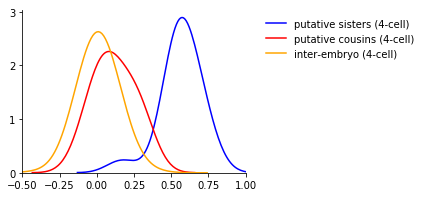

In [107]:
#plot the pairwise correlations of chromosome positioning for pairs within and between 4-cell embryos 
bw=0.1
fig2,ax2=plt.subplots(figsize=(4,3))
sns.distplot(putative_sis_corrs, hist = False, kde = True,ax=ax2,color='blue',label='putative sisters (4-cell)',
            kde_kws={'bw': bw})
sns.distplot(putative_cous_corrs, hist = False, kde = True,ax=ax2,color='red',label='putative cousins (4-cell)',
            kde_kws={'bw': bw})
sns.distplot(corr_arrays[3], hist = False, kde = True,ax=ax2,color='orange',label='inter-embryo (4-cell)',
            kde_kws={'bw': bw})

ax2.set_xlim(-0.5,1)
#ax.legend(loc='upper left')
ax2.legend(bbox_to_anchor=(1.05, 1),frameon=False)

ax2.set_yticks((0,1,2,3))

# Hide the right and top bounding areas
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

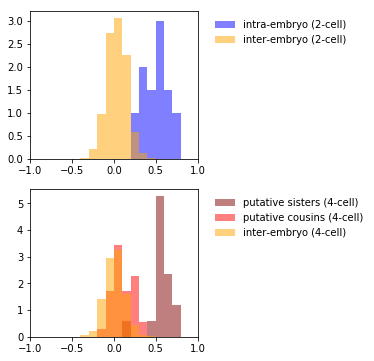

In [108]:
#plot histograms of the same plots
#histograms
fig,ax=plt.subplots(2,figsize=(3,6))
ax[0].hist([corr_arrays[0]],bins=np.linspace(-1,1,21),color='blue',alpha=0.5,density=True,label='intra-embryo (2-cell)')
ax[0].hist([corr_arrays[1]],bins=np.linspace(-1,1,21),color='orange',alpha=0.5,density=True,label='inter-embryo (2-cell)')

ax[1].hist([putative_sis_corrs],bins=np.linspace(-1,1,21),color='maroon',alpha=0.5,density=True,label='putative sisters (4-cell)')
ax[1].hist([putative_cous_corrs],bins=np.linspace(-1,1,21),color='red',alpha=0.5,density=True,label='putative cousins (4-cell)')
ax[1].hist([corr_arrays[3]],bins=np.linspace(-1,1,21),color='orange',alpha=0.5,density=True,label='inter-embryo (4-cell)')

for i in [0,1]:
    ax[i].set_xlim(-1,1)
    ax[i].legend(bbox_to_anchor=(1.05, 1),frameon=False)